# Week 7 - Model Monitoring and Maintenance

In [ ]:
# Install packages
!pip install pyspark
!pip install findspark
!pip install dill

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 3.7 MB/s eta 0:00:00


In [ ]:
# Set up pyspark
import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder \
        .master('local[*]') \
        .appName('Basics') \
        .getOrCreate()

print(spark.version)

3.5.4


In [ ]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#### Assign home directory
home_dir = '/content/drive/MyDrive/ TERM 7/MACHINE/churn_prediction'

In [ ]:
# Define functions
# Import additional packages
import datetime
import csv
import yaml
import io
import dill as pickle
import os

def get_datetime():
    """Returns datetime for filename use.

    :return: datetime
    :rtype: string
    """
    stamp = datetime.datetime.now()
    datetime_name = f"{stamp.year:04}{stamp.month:02}{stamp.day:02}_{stamp.hour:02}{stamp.minute:02}"
    print(datetime_name)
    return datetime_name

print('Functions ready!')

Functions ready!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read data using pyspark
df_2018_demo = spark.read.csv(f"{home_dir}/data/week2_data_for_student_lab.csv.gz", inferSchema=True, header=True)
print(f"{df_2018_demo.show(5)}")
df_2018_demo.createOrReplaceTempView("df_2018_demo_view")

+----------------+-----------+--------------------+------+-------+--------+------+-----+---------+-----------+------+-------------+
|transaction_date|member_type|           member_id|gender|product|quantity|amount|  age|card_type|branch_name|region|category_name|
+----------------+-----------+--------------------+------+-------+--------+------+-----+---------+-----------+------+-------------+
|      2018-04-01|     member|ff96777d-cfda-11e...|FEMALE|   3267|      16|  5100|30-35|  REGULAR|    E_Store|     3|  FROZEN FOOD|
|      2018-04-09|     member|00d89024-cfdb-11e...|FEMALE|   6748|       1|  1100|55-60|  REGULAR|    A_Store|     1|          PET|
|      2018-04-01|     member|00858b3b-cfdb-11e...|FEMALE|    420|       4|  5300|55-60|  REGULAR|    A_Store|     1|          PET|
|      2018-04-13|     member|001035ed-cfdb-11e...|FEMALE|   3178|      16|  5600|45-50|  REGULAR|    A_Store|     1|      GADGETS|
|      2018-04-15|     member|ff5fafeb-cfda-11e...|FEMALE|   2727|      19| 

In [ ]:
# Check first 5 rows of data
spark.sql('''
SELECT
  *
FROM
  df_2018_demo_view
LIMIT
  5
''').show()

+----------------+-----------+--------------------+------+-------+--------+------+-----+---------+-----------+------+-------------+
|transaction_date|member_type|           member_id|gender|product|quantity|amount|  age|card_type|branch_name|region|category_name|
+----------------+-----------+--------------------+------+-------+--------+------+-----+---------+-----------+------+-------------+
|      2018-04-01|     member|ff96777d-cfda-11e...|FEMALE|   3267|      16|  5100|30-35|  REGULAR|    E_Store|     3|  FROZEN FOOD|
|      2018-04-09|     member|00d89024-cfdb-11e...|FEMALE|   6748|       1|  1100|55-60|  REGULAR|    A_Store|     1|          PET|
|      2018-04-01|     member|00858b3b-cfdb-11e...|FEMALE|    420|       4|  5300|55-60|  REGULAR|    A_Store|     1|          PET|
|      2018-04-13|     member|001035ed-cfdb-11e...|FEMALE|   3178|      16|  5600|45-50|  REGULAR|    A_Store|     1|      GADGETS|
|      2018-04-15|     member|ff5fafeb-cfda-11e...|FEMALE|   2727|      19| 

In [ ]:
# Checking the partition dates
spark.sql('''
SELECT
  MIN(transaction_date)
  ,MAX(transaction_date)
FROM
  df_2018_demo_view
''').show()

+---------------------+---------------------+
|min(transaction_date)|max(transaction_date)|
+---------------------+---------------------+
|           2018-01-01|           2018-08-10|
+---------------------+---------------------+



In [ ]:
# Checking the count of transactions for the month of August
spark.sql('''
SELECT
  COUNT(CASE WHEN transaction_date BETWEEN '2018-08-01' AND '2018-08-31' THEN 1 ELSE NULL END) AS aug_txns
FROM
  df_2018_demo_view
''').show()

+--------+
|aug_txns|
+--------+
|   42902|
+--------+



In [ ]:
# Checking the count of transaction dates for the month of August + its distinct count of member ID
spark.sql('''
SELECT
  COUNT(CASE WHEN transaction_date BETWEEN '2018-08-01' AND '2018-08-31' THEN member_id ELSE NULL END) AS cnt_member_id
   ,COUNT(DISTINCT CASE WHEN transaction_date BETWEEN '2018-08-01' AND '2018-08-31' THEN member_id ELSE NULL END) AS cntd_member_id
FROM
  df_2018_demo_view
''').show()

+-------------+--------------+
|cnt_member_id|cntd_member_id|
+-------------+--------------+
|        42902|         23896|
+-------------+--------------+



In [ ]:
# Count target definition
spark.sql('''
WITH
customer_base AS (
SELECT
  DISTINCT member_id
FROM
  df_2018_demo_view
WHERE
  transaction_date BETWEEN '2018-08-01' AND '2018-08-31'
)
,customer_base_joined_with_past_3_months_txn AS (
SELECT
  a.member_id
  ,b.quantity
  ,b.transaction_date
FROM
  customer_base AS a
LEFT JOIN
  df_2018_demo_view AS b
ON
  a.member_id = b.member_id
AND
  b.transaction_date BETWEEN '2018-05-01' AND '2018-07-31'
)
,customer_base_with_aggregated_total_txns_per_month AS (
SELECT
   member_id
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-05-01' AND '2018-07-31' THEN quantity ELSE 0 END) AS sum_quantity
  ,'2018-06-01' AS partition_month
FROM
  customer_base_joined_with_past_3_months_txn
GROUP BY
  member_id
)
,customers_with_target_definition AS (
SELECT
  *
  ,CASE
    WHEN sum_quantity = 0 THEN 1
    ELSE 0
    END AS target
FROM
  customer_base_with_aggregated_total_txns_per_month
)
,count_customers_with_target_definition AS (
SELECT
  target
  ,COUNT(member_id) AS cnt_member_id
  ,COUNT(DISTINCT member_id) AS cntd_member_id
FROM
  customers_with_target_definition
GROUP BY
  target
)


SELECT
  *
FROM
  count_customers_with_target_definition
''').show()

+------+-------------+--------------+
|target|cnt_member_id|cntd_member_id|
+------+-------------+--------------+
|     1|         8902|          8902|
|     0|        14994|         14994|
+------+-------------+--------------+



In [ ]:
# Compute PCC
(8902/(8902+14994))**2 + (14994/(8902+14994))**2

0.532496708479743

In [ ]:
# Compute PCC * 1.25
(8902/(8902+14994))**2 + (14994/(8902+14994))**2 * 1.25

0.6309260551582245

In [ ]:
# Show first 5 rows of features for modeling
spark.sql('''
WITH
customer_base AS (
SELECT
  DISTINCT member_id
FROM
  df_2018_demo_view
WHERE
  transaction_date BETWEEN '2018-08-01' AND '2018-08-31'
)
,customer_base_joined_with_past_3_months_txn AS (
SELECT
  a.member_id
  ,b.quantity
  ,b.transaction_date
FROM
  customer_base AS a
LEFT JOIN
  df_2018_demo_view AS b
ON
  a.member_id = b.member_id
AND
  b.transaction_date BETWEEN '2018-05-01' AND '2018-07-31'
)
,customer_base_with_aggregated_total_txns_per_month AS (
SELECT
   member_id
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-05-01' AND '2018-07-31' THEN quantity ELSE 0 END) AS sum_quantity
  ,'2018-06-01' AS partition_date
FROM
  customer_base_joined_with_past_3_months_txn
GROUP BY
  member_id
)
,customers_with_target_definition AS (
SELECT
  *
  ,CASE
    WHEN sum_quantity = 0 THEN 1
    ELSE 0
    END AS target
FROM
  customer_base_with_aggregated_total_txns_per_month
)
,count_customers_with_target_definition AS (
SELECT
  target
  ,COUNT(member_id) AS cnt_member_id
  ,COUNT(DISTINCT member_id) AS cntd_member_id
FROM
  customers_with_target_definition
GROUP BY
  target
)
,customers_joined_with_features AS (
SELECT
  a.member_id
  ,b.quantity
  ,b.amount
  ,b.category_name
  ,b.transaction_date
FROM
  customers_with_target_definition AS a
LEFT JOIN
  df_2018_demo_view AS b
ON
  a.member_id = b.member_id
AND
  b.transaction_date BETWEEN '2018-01-01' AND '2018-03-31'
)
,aggregated_categories AS (
SELECT
   member_id
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name IN ('ACCESSORIES') THEN amount ELSE 0 END) AS sum_amount_accessories
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name IN ('APPLIANCES') THEN amount ELSE 0 END) AS sum_amount_appliances
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name IN ('CLEANERS') THEN amount ELSE 0 END) AS sum_amount_cleaners
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name IN ('CLOTHES') THEN amount ELSE 0 END) AS sum_amount_clothes
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name IN ('FOOD') THEN amount ELSE 0 END) AS sum_amount_food
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name IN ('FROZEN FOOD') THEN amount ELSE 0 END) AS sum_amount_frozen_food
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name IN ('GADGETS') THEN amount ELSE 0 END) AS sum_amount_gadgets
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name IN ('HARDWARE') THEN amount ELSE 0 END) AS sum_amount_hardware
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name IN ('PET') THEN amount ELSE 0 END) AS sum_amount_pet
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name IN ('SHOES') THEN amount ELSE 0 END) AS sum_amount_shoes

  ,SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' THEN amount ELSE 0 END) AS sum_amount_total
  ,AVG(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' THEN amount ELSE 0 END) AS avg_amount_total
  ,MIN(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' THEN amount ELSE 0 END) AS min_amount_total
  ,MAX(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' THEN amount ELSE 0 END) AS max_amount_total


FROM
  customers_joined_with_features
GROUP BY
  member_id
)
,customers_with_target_joined_with_features AS (
SELECT
  a.member_id
  ,a.target
  ,a.partition_date
  ,b.sum_amount_accessories
  ,b.sum_amount_appliances
  ,b.sum_amount_cleaners
  ,b.sum_amount_clothes
  ,b.sum_amount_food
  ,b.sum_amount_frozen_food
  ,b.sum_amount_gadgets
  ,b.sum_amount_hardware
  ,b.sum_amount_pet
  ,b.sum_amount_shoes
  ,b.sum_amount_total
  ,b.avg_amount_total
  ,b.min_amount_total
  ,b.max_amount_total
FROM
  customers_with_target_definition AS a
LEFT JOIN
  aggregated_categories AS b
ON
  a.member_id = b.member_id
)

SELECT
  *
FROM
  customers_with_target_joined_with_features LIMIT 5
  --count_customers_with_target_definition
''').show()

+--------------------+------+--------------+----------------------+---------------------+-------------------+------------------+---------------+----------------------+------------------+-------------------+--------------+----------------+----------------+----------------+----------------+----------------+
|           member_id|target|partition_date|sum_amount_accessories|sum_amount_appliances|sum_amount_cleaners|sum_amount_clothes|sum_amount_food|sum_amount_frozen_food|sum_amount_gadgets|sum_amount_hardware|sum_amount_pet|sum_amount_shoes|sum_amount_total|avg_amount_total|min_amount_total|max_amount_total|
+--------------------+------+--------------+----------------------+---------------------+-------------------+------------------+---------------+----------------------+------------------+-------------------+--------------+----------------+----------------+----------------+----------------+----------------+
|002480e8-cfdb-11e...|     0|    2018-06-01|                     0|            

In [ ]:
# Create scoring ABT (analytics base table)
df_sabt = spark.sql('''
WITH
customer_base AS (
SELECT
  DISTINCT member_id
FROM
  df_2018_demo_view
WHERE
  transaction_date BETWEEN '2018-08-01' AND '2018-08-31'
)
,customer_base_joined_with_past_3_months_txn AS (
SELECT
  a.member_id
  ,b.quantity
  ,b.transaction_date
FROM
  customer_base AS a
LEFT JOIN
  df_2018_demo_view AS b
ON
  a.member_id = b.member_id
AND
  b.transaction_date BETWEEN '2018-05-01' AND '2018-07-31'
)
,customer_base_with_aggregated_total_txns_per_month AS (
SELECT
   member_id
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-05-01' AND '2018-07-31' THEN quantity ELSE 0 END) AS sum_quantity
  ,'2018-06-01' AS partition_date
FROM
  customer_base_joined_with_past_3_months_txn
GROUP BY
  member_id
)
,customers_with_target_definition AS (
SELECT
  *
  ,CASE
    WHEN sum_quantity = 0 THEN 1
    ELSE 0
    END AS target
FROM
  customer_base_with_aggregated_total_txns_per_month
)
,count_customers_with_target_definition AS (
SELECT
  target
  ,COUNT(member_id) AS cnt_member_id
  ,COUNT(DISTINCT member_id) AS cntd_member_id
FROM
  customers_with_target_definition
GROUP BY
  target
)
,customers_joined_with_features AS (
SELECT
  a.member_id
  ,b.quantity
  ,b.amount
  ,b.category_name
  ,b.transaction_date
FROM
  customers_with_target_definition AS a
LEFT JOIN
  df_2018_demo_view AS b
ON
  a.member_id = b.member_id
AND
  b.transaction_date BETWEEN '2018-01-01' AND '2018-03-31'
)
,aggregated_categories AS (
SELECT
   member_id
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name IN ('ACCESSORIES') THEN amount ELSE 0 END) AS sum_amount_accessories
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name IN ('APPLIANCES') THEN amount ELSE 0 END) AS sum_amount_appliances
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name IN ('CLEANERS') THEN amount ELSE 0 END) AS sum_amount_cleaners
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name IN ('CLOTHES') THEN amount ELSE 0 END) AS sum_amount_clothes
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name IN ('FOOD') THEN amount ELSE 0 END) AS sum_amount_food
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name IN ('FROZEN FOOD') THEN amount ELSE 0 END) AS sum_amount_frozen_food
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name IN ('GADGETS') THEN amount ELSE 0 END) AS sum_amount_gadgets
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name IN ('HARDWARE') THEN amount ELSE 0 END) AS sum_amount_hardware
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name IN ('PET') THEN amount ELSE 0 END) AS sum_amount_pet
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name IN ('SHOES') THEN amount ELSE 0 END) AS sum_amount_shoes

  ,SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' THEN amount ELSE 0 END) AS sum_amount_total
  ,AVG(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' THEN amount ELSE 0 END) AS avg_amount_total
  ,MIN(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' THEN amount ELSE 0 END) AS min_amount_total
  ,MAX(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' THEN amount ELSE 0 END) AS max_amount_total


FROM
  customers_joined_with_features
GROUP BY
  member_id
)
,customers_with_target_joined_with_features AS (
SELECT
  a.member_id
  ,a.target
  ,a.partition_date
  ,b.sum_amount_accessories
  ,b.sum_amount_appliances
  ,b.sum_amount_cleaners
  ,b.sum_amount_clothes
  ,b.sum_amount_food
  ,b.sum_amount_frozen_food
  ,b.sum_amount_gadgets
  ,b.sum_amount_hardware
  ,b.sum_amount_pet
  ,b.sum_amount_shoes
  ,b.sum_amount_total
  ,b.avg_amount_total
  ,b.min_amount_total
  ,b.max_amount_total
FROM
  customers_with_target_definition AS a
LEFT JOIN
  aggregated_categories AS b
ON
  a.member_id = b.member_id
)

SELECT
  *
FROM
  customers_with_target_joined_with_features
  --LIMIT 5
  --count_customers_with_target_definition
''')
df_sabt.createOrReplaceTempView("df_sabt_view")

In [ ]:
# Save modeling ABT as pandas
pdf_sabt = df_sabt.toPandas()
pdf_sabt.head()

,member_id,target,partition_date,sum_amount_accessories,sum_amount_appliances,sum_amount_cleaners,sum_amount_clothes,sum_amount_food,sum_amount_frozen_food,sum_amount_gadgets,sum_amount_hardware,sum_amount_pet,sum_amount_shoes,sum_amount_total,avg_amount_total,min_amount_total,max_amount_total
0,00000871-cfdb-11eb-a068-d8f2ca37414f,1,2018-06-01,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0
1,00000882-cfdb-11eb-8a9d-d8f2ca37414f,1,2018-06-01,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0
2,00000888-cfdb-11eb-8c24-d8f2ca37414f,0,2018-06-01,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0
3,00000894-cfdb-11eb-9d31-d8f2ca37414f,0,2018-06-01,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0
4,000008d8-cfdb-11eb-b3a6-d8f2ca37414f,0,2018-06-01,0,100,0,0,0,0,0,0,0,0,100,100.0,100,100


In [ ]:
# Check column names in data
pdf_sabt.columns

Index(['member_id', 'target', 'partition_date', 'sum_amount_accessories',
       'sum_amount_appliances', 'sum_amount_cleaners', 'sum_amount_clothes',
       'sum_amount_food', 'sum_amount_frozen_food', 'sum_amount_gadgets',
       'sum_amount_hardware', 'sum_amount_pet', 'sum_amount_shoes',
       'sum_amount_total', 'avg_amount_total', 'min_amount_total',
       'max_amount_total'],
      dtype='object')

In [ ]:
# Check summary statistics
pdf_sabt[['sum_amount_accessories',
       'sum_amount_appliances', 'sum_amount_cleaners', 'sum_amount_clothes',
       'sum_amount_food', 'sum_amount_frozen_food', 'sum_amount_gadgets',
       'sum_amount_hardware', 'sum_amount_pet', 'sum_amount_shoes',
       'avg_amount_total', 'min_amount_total', 'max_amount_total']].describe().T

,count,mean,std,min,25%,50%,75%,max
sum_amount_accessories,23896.0,386.516572,1677.602735,0.0,0.0,0.0,0.000000,23800.0
sum_amount_appliances,23896.0,409.742216,1706.493292,0.0,0.0,0.0,0.000000,21700.0
sum_amount_cleaners,23896.0,1399.154670,3677.942503,0.0,0.0,0.0,0.000000,41900.0
sum_amount_clothes,23896.0,412.604620,1727.970402,0.0,0.0,0.0,0.000000,22400.0
sum_amount_food,23896.0,358.160362,1607.369624,0.0,0.0,0.0,0.000000,24100.0
sum_amount_frozen_food,23896.0,430.122196,1799.650963,0.0,0.0,0.0,0.000000,34600.0
sum_amount_gadgets,23896.0,372.811349,1615.234875,0.0,0.0,0.0,0.000000,23600.0
sum_amount_hardware,23896.0,367.936056,1626.079471,0.0,0.0,0.0,0.000000,27400.0
sum_amount_pet,23896.0,1085.428524,2915.211286,0.0,0.0,0.0,0.000000,41000.0
sum_amount_shoes,23896.0,368.898560,1616.805773,0.0,0.0,0.0,0.000000,25800.0


In [ ]:
# Check summary statistics per target definition
pdf_sabt.groupby(['target'])[['sum_amount_accessories',
       'sum_amount_appliances', 'sum_amount_cleaners', 'sum_amount_clothes',
       'sum_amount_food', 'sum_amount_frozen_food', 'sum_amount_gadgets',
       'sum_amount_hardware', 'sum_amount_pet', 'sum_amount_shoes',
       'avg_amount_total', 'min_amount_total', 'max_amount_total']].describe().T

target                                   0             1
sum_amount_accessories count  14994.000000   8902.000000
                       mean     386.607977    386.362615
                       std     1697.951160   1642.853965
                       min        0.000000      0.000000
                       25%        0.000000      0.000000
                       50%        0.000000      0.000000
                       75%        0.000000      0.000000
                       max    23800.000000  18000.000000
sum_amount_appliances  count  14994.000000   8902.000000
                       mean     402.907830    421.253651
                       std     1682.491975   1746.209042
                       min        0.000000      0.000000
                       25%        0.000000      0.000000
                       50%        0.000000      0.000000
                       75%        0.000000      0.000000
                       max    21700.000000  18900.000000
sum_amount_cleaners    count  14994.000000   8902.000000
                       mean    1385.540883   1422.084925
                       std     3677.079926   3679.487621
                       min        0.000000      0.000000
                       25%        0.000000      0.000000
                       50%        0.000000      0.000000
                       75%        0.000000      0.000000
                       max    41900.000000  41200.000000
sum_amount_clothes     count  14994.000000   8902.000000
                       mean     420.401494    399.472029
                       std     1755.043977   1681.399912
                       min        0.000000      0.000000
                       25%        0.000000      0.000000
                       50%        0.000000      0.000000
                       75%        0.000000      0.000000
                       max    22400.000000  16400.000000
sum_amount_food        count  14994.000000   8902.000000
                       mean     362.958517    350.078634
                       std     1605.450081   1610.655555
                       min        0.000000      0.000000
                       25%        0.000000      0.000000
                       50%        0.000000      0.000000
                       75%        0.000000      0.000000
                       max    20600.000000  24100.000000
sum_amount_frozen_food count  14994.000000   8902.000000
                       mean     429.671869    430.880701
                       std     1795.512852   1806.700286
                       min        0.000000      0.000000
                       25%        0.000000      0.000000
                       50%        0.000000      0.000000
                       75%        0.000000      0.000000
                       max    34600.000000  22700.000000
sum_amount_gadgets     count  14994.000000   8902.000000
                       mean     382.766440    356.043586
                       std     1638.596184   1575.052311
                       min        0.000000      0.000000
                       25%        0.000000      0.000000
                       50%        0.000000      0.000000
                       75%        0.000000      0.000000
                       max    23600.000000  20200.000000
sum_amount_hardware    count  14994.000000   8902.000000
                       mean     364.852608    373.129634
                       std     1606.204980   1659.094785
                       min        0.000000      0.000000
                       25%        0.000000      0.000000
                       50%        0.000000      0.000000
                       75%        0.000000      0.000000
                       max    25400.000000  27400.000000
sum_amount_pet         count  14994.000000   8902.000000
                       mean    1098.379352   1063.614918
                       std     2940.791826   2871.642026
                       min        0.000000      0.000000
                       25%        0.000000      0.000000
          

In [ ]:
# Copy data for modeling
data = pdf_sabt[['target', 'sum_amount_accessories',
       'sum_amount_appliances', 'sum_amount_cleaners', 'sum_amount_clothes',
       'sum_amount_food', 'sum_amount_frozen_food', 'sum_amount_gadgets',
       'sum_amount_hardware', 'sum_amount_pet', 'sum_amount_shoes',
       'avg_amount_total', 'min_amount_total', 'max_amount_total'
       ]].copy()

In [ ]:
# Separate target variable and features
y_oot = data['target']
X_oot = data.drop(['target'], axis=1)

In [ ]:
# # Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# # Model
# estimator = LogisticRegression()

# # Create transformers for categorical and numeric features
# preprocessor = ColumnTransformer(
#     transformers=[
#         #('cat_onehot', OneHotEncoder(handle_unknown='ignore'), [])
#         #,
#          ('num_standard', StandardScaler(), ['sum_amount_accessories',
#        'sum_amount_appliances', 'sum_amount_cleaners', 'sum_amount_clothes',
#        'sum_amount_food', 'sum_amount_frozen_food', 'sum_amount_gadgets',
#        'sum_amount_hardware', 'sum_amount_pet', 'sum_amount_shoes'])
#         #,('num_minmax', MinMaxScaler(), [])
#     ],
#     remainder='passthrough',
# )

# # Create a logistic regression model using a pipeline
# pipeline = Pipeline([
#     ('preprocessor', preprocessor)
#     ,('estimator', estimator)
# ])

# # Fit training data into model pipeline
# pipeline.fit(X_train, y_train)

In [ ]:
# #### Set model name

# prefix_name="aggregated_3_months"

# model_name = f"churn_prediction_{get_datetime()}_{prefix_name}"
# print(f"{model_name}")

In [ ]:
# #### Save model

# import pickle

# # Assuming you have a fitted model in 'pipeline'
# with open(f'{home_dir}/models/{model_name}.pickle', 'wb') as f:
#   pickle.dump(pipeline, f)

# print(f'Model {model_name} saved!')

In [ ]:
#### Retrieve model

model_name = 'churn_prediction_20250216_1436_aggregated_3_months'

with open(f'{home_dir}/models/{model_name}.pickle', 'rb') as f:
  loaded_pipeline = pickle.load(f)

print(f'Model {model_name} ready!')

Model churn_prediction_20250216_1436_aggregated_3_months ready!


Accuracy: 0.63
Precision: 0.00
Recall: 0.00

Confusion Matrix:
[[14994     0]
 [ 8902     0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


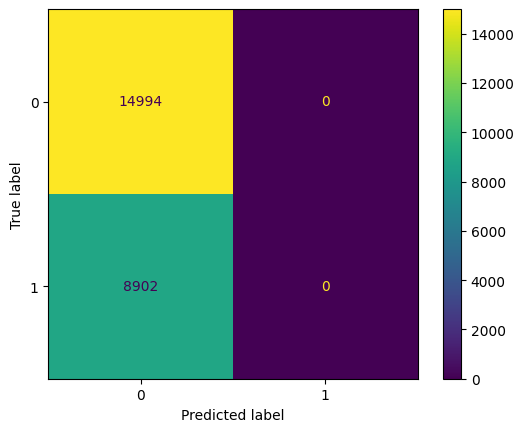

In [ ]:
# Make predictions on the out of time dataset
y_pred_oot = loaded_pipeline.predict(X_oot)

# Evaluate the model
accuracy_oot = accuracy_score(y_oot, y_pred_oot)
precision_oot = precision_score(y_oot, y_pred_oot)
recall_oot = recall_score(y_oot, y_pred_oot)
cm_oot = confusion_matrix(y_oot, y_pred_oot)

print(f"Accuracy: {accuracy_oot:.2f}")
print(f"Precision: {precision_oot:.2f}")
print(f"Recall: {recall_oot:.2f}")
print(f"\nConfusion Matrix:")
print(cm_oot)

cmd_train = ConfusionMatrixDisplay(cm_oot)
cmd_train.plot()

In [ ]:
# # Make predictions on the test set
# y_pred_test = loaded_pipeline.predict(X_test)

# # Evaluate the model
# accuracy_test = accuracy_score(y_test, y_pred_test)
# precision_test = precision_score(y_test, y_pred_test)
# recall_test = recall_score(y_test, y_pred_test)
# cm_test = confusion_matrix(y_test, y_pred_test)

# print(f"Accuracy: {accuracy_test:.2f}")
# print(f"Precision: {precision_test:.2f}")
# print(f"Recall: {recall_test:.2f}")
# print(f"\nConfusion Matrix:")
# print(cm_test)

# cmd_test = ConfusionMatrixDisplay(cm_test)
# cmd_test.plot()

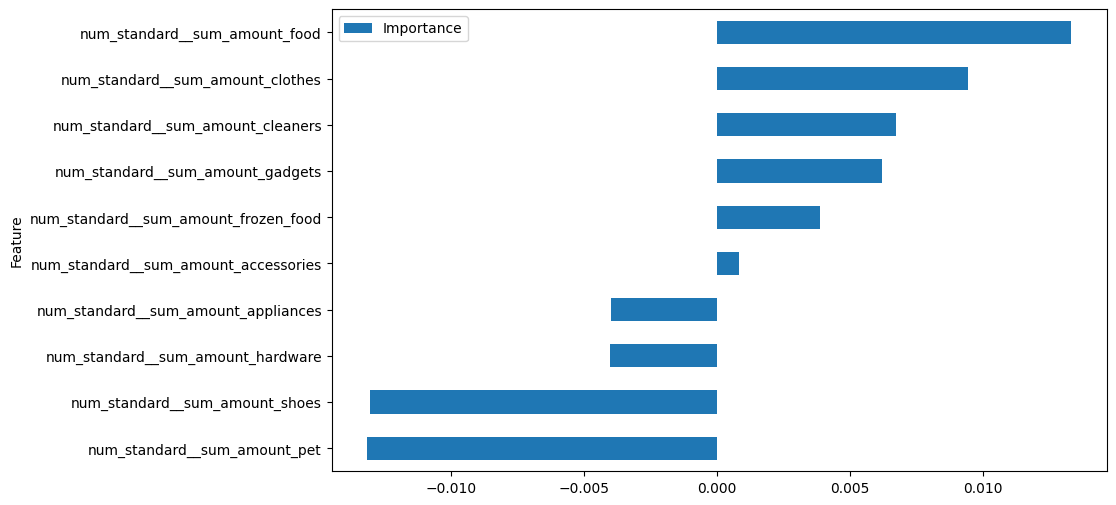

Intercept: -0.7881960091617355


In [ ]:
#### Get coefficients & intercept

coefficients = loaded_pipeline.named_steps.estimator.coef_[0]
feature_names = loaded_pipeline.named_steps.preprocessor.get_feature_names_out()

feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': coefficients})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.show()

intercept = loaded_pipeline.named_steps.estimator.intercept_[0]
print(f'Intercept: {intercept}')

# Observation and Analysis

Based on my analysis, the Analytics Base Table (ABT) is systematically built, ensuring that relevant features are aggregated and structured for modeling. The stored churn prediction model is retrieved and applied to the out-of-time dataset for evaluation. However, the model exhibits poor performance, with a 63% accuracy but a precision and recall of 0.00, indicating that it fails to identify positive cases. The confusion matrix confirms that all predictions fall into the majority class, suggesting an issue with class imbalance or model thresholding. The pipeline's feature importance analysis is useful for further refinements, but adjustments such as rebalancing the dataset or fine-tuning model hyperparameters may be required to improve predictive performance.